In [1]:
import numpy as np 
import matplotlib.pyplot as plt
import pandas as pd
import torch
from netCDF4 import Dataset
import netCDF4 as nc
import os
plt.style.use("classic")

/home/resifis/anaconda3/envs/kaustenv/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Setup

In [2]:
DATAPATH = os.environ.get("DATAPATH","/home/resifis/Desktop/kaustcode/Packages/processed_data")
timestep = 1

In [3]:
data_path = os.path.join(DATAPATH,"aod.nc") 
netcdf_dataset_aod = Dataset(data_path,mode = 'r')

In [4]:
aod = torch.tensor(netcdf_dataset_aod.variables["aod5503d"][timestep:timestep+2,:,:])

In [5]:
aod = torch.flip(aod,dims = [1])

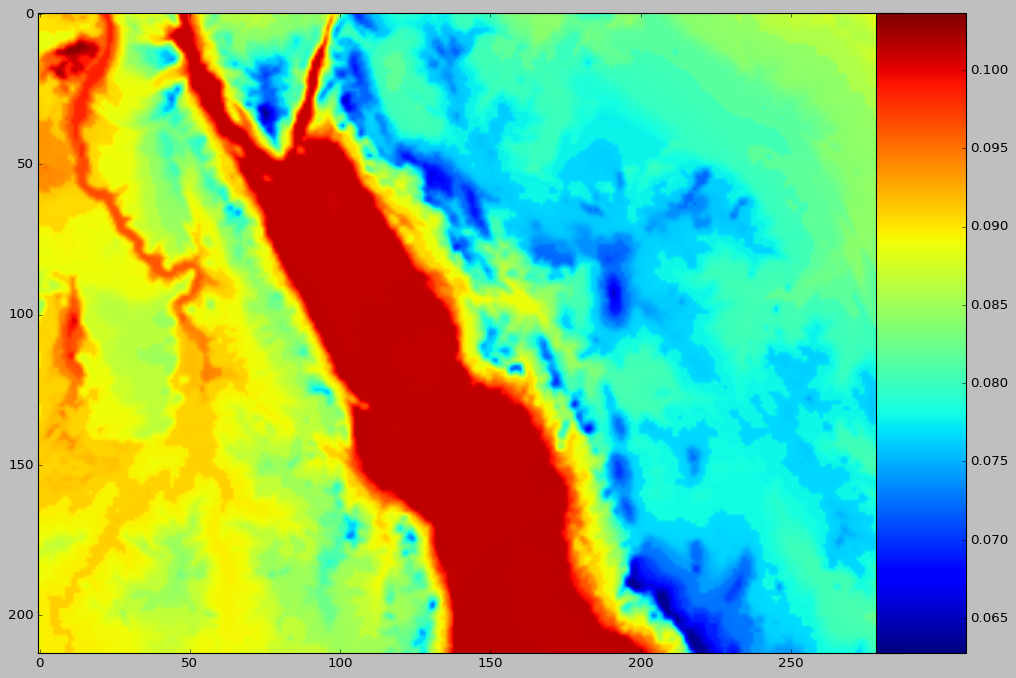

In [6]:
plt.figure(figsize = (15,10))
plt.imshow(aod[0])
cax = plt.axes([0.85, 0.1, 0.075, 0.8])
plt.colorbar(cax=cax)

# Preprocessing

## SSIM Loss

In [7]:
import torch
import torch.nn.functional as F
from torch.autograd import Variable
import numpy as np
from math import exp

def gaussian(window_size, sigma):
    gauss = torch.Tensor([exp(-(x - window_size//2)**2/float(2*sigma**2)) for x in range(window_size)])
    return gauss/gauss.sum()


def create_window_3D(window_size, channel):
    _1D_window = gaussian(window_size, 1.5).unsqueeze(1)
    _2D_window = _1D_window.mm(_1D_window.t())
    _3D_window = _1D_window.mm(_2D_window.reshape(1, -1)).reshape(window_size, window_size, window_size).float().unsqueeze(0).unsqueeze(0)
    window = Variable(_3D_window.expand(channel, 1, window_size, window_size, window_size).contiguous())
    return window
    
def _ssim_3D(img1, img2, window, window_size, channel, size_average = True):
    mu1 = F.conv3d(img1, window, padding = window_size//2, groups = channel)
    mu2 = F.conv3d(img2, window, padding = window_size//2, groups = channel)

    mu1_sq = mu1.pow(2)
    mu2_sq = mu2.pow(2)

    mu1_mu2 = mu1*mu2

    sigma1_sq = F.conv3d(img1*img1, window, padding = window_size//2, groups = channel) - mu1_sq
    sigma2_sq = F.conv3d(img2*img2, window, padding = window_size//2, groups = channel) - mu2_sq
    sigma12 = F.conv3d(img1*img2, window, padding = window_size//2, groups = channel) - mu1_mu2

    C1 = 0.01**2
    C2 = 0.03**2

    ssim_map = ((2*mu1_mu2 + C1)*(2*sigma12 + C2))/((mu1_sq + mu2_sq + C1)*(sigma1_sq + sigma2_sq + C2))

    if size_average:
        return ssim_map.mean()
    else:
        return ssim_map.mean(1).mean(1).mean(1)
    


class SSIM3D(torch.nn.Module):
    def __init__(self, window_size = 11, size_average = True):
        super(SSIM3D, self).__init__()
        self.window_size = window_size
        self.size_average = size_average
        self.channel = 1
        self.window = create_window_3D(window_size, self.channel)

    def forward(self, img1, img2):
        (_, channel, _, _, _) = img1.size()

        if channel == self.channel and self.window.data.type() == img1.data.type():
            window = self.window
        else:
            window = create_window_3D(self.window_size, channel)
            
            if img1.is_cuda:
                window = window.cuda(img1.get_device())
            window = window.type_as(img1)
            
            self.window = window
            self.channel = channel


        return _ssim_3D(img1, img2, window, self.window_size, channel, self.size_average)

In [8]:
torch.tensor(netcdf_dataset_aod.variables["aod5503d"][timestep:timestep+2,:,:]).shape

torch.Size([2, 213, 288])

In [9]:
import torch
from torch.autograd import Variable
img1 = torch.tensor(netcdf_dataset_aod.variables["aod5503d"][2:4,:,:],requires_grad = True).unsqueeze(0).unsqueeze(0)
img2 = torch.tensor(netcdf_dataset_aod.variables["aod5503d"][3:5,:,:]).unsqueeze(0).unsqueeze(0)
if torch.cuda.is_available():
    device = torch.device("cuda:1")
    img1 = img1.to(device)
    img2 = img2.to(device)
ssim_loss = SSIM3D(window_size = 11)

print(ssim_loss(img1, img2))

tensor(1.0000, device='cuda:1', grad_fn=<MeanBackward0>)


## PSNR

In [10]:
class PSNR(torch.nn.Module):
    def __init__(self):
        super(PSNR,self).__init__()
        
    def _mse(self,im1,im2):
        mse = torch.nn.MSELoss()
        return mse(im1,im2)
    def forward(self,im1,im2):
        mse_loss = self._mse(im1,im2)
        psnr_loss = 10 * torch.log10(1/mse_loss)
        return -psnr_loss

In [11]:
psnr = PSNR()

In [12]:
psnr(img1,img2)

tensor(-85.4644, device='cuda:1', grad_fn=<NegBackward0>)

In [13]:
import torch.nn as nn
class Loss(nn.Module):
    def __init__(self,loss_name):
        super(Loss,self).__init__()
        self.mse = nn.MSELoss()
        self.l1  = nn.L1Loss()
        self.loss_name = loss_name
        self.psnr = PSNR()
        self.ssim = SSIM3D(window_size = 11)
        
    def forward(self,yhat,y):
        if self.loss_name == "RMSE":
            return torch.sqrt(self.mse(yhat,y))
        elif self.loss_name == "MSE":
            return self.mse(yhat,y)
        elif self.loss_name == "L1Loss":
            return self.l1(yhat,y)
        elif self.loss_name == "PSNR":
            return self.psnr(yhat,y)
        elif self.loss_name == "SSIM":
            return 1-self.ssim(yhat,y)

In [16]:
loss = Loss("PSNR")

In [17]:
loss(img1,img2)

tensor(-85.4644, device='cuda:1', grad_fn=<NegBackward0>)